# Oil & Gas Equipment Failure Prediction

## Introduction

This assignment involves an FPSO (Floating Production, Storage, and Offloading) vessel, and we need to address an equipment failure problem.

An FPSO is a floating production system that receives fluids from a subsea reservoir through risers, which then separate fluids into crude oil, natural gas, water and impurities within the topsides production facilities onboard. Crude oil stored in the storage tanks of the FPSO is offloaded onto shuttle tankers to go to market or for further refining onshore.

To enable the operations of an FPSO, sensors are used to make sure the equipment does not fail. These sensors measure different parameters of the equipment in different setups configurations over time. We want to investigate one piece of equipment in different time cycles to understand what characteristics and parameters of the sensors might indicate that the equipment is on the verge of failing.

In summary, we need to create a data product that is able to make predictions about when the equipment will fail. This way, we can reduce costs with maintenance, and reduce delays caused by time-consuming unexpected stops.


In [46]:
## --- Visualization and data structures libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## --- Preprocessing handy functions
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import make_pipeline

## --- Machine learning libraries
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

## --- Libraries for evaluating model performance
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

## --- Handy user-defined functions

from subroutines import display_percent_count_plot, cf_matrix_labels, dist_medians
from subroutines import reduce_mem_usage, display_feat_import

import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

### First Look

We first have a look at the dataset we were given so that we can get familiarized with the features and the data types. Since the column names are self-explanatory, I'll not expend time in explaining the meaning of each feature. Below we can see the data types of each column, and whether there are missing values in the dataset.

In [2]:
df = pd.read_excel('O&G Equipment Data.xlsx')
df.head(10)

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,False
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,False
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,False
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,False
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,False
5,6,1,2,58.336085,64.426353,56.479227,78.623742,65.911528,78.886214,False
6,7,1,3,77.937777,83.146657,77.800590,109.679048,86.230728,99.681179,False
7,8,1,4,78.563506,130.089912,110.479871,130.997020,85.218562,98.467375,False
8,9,3,7,77.486218,104.462955,77.390388,159.423483,115.211934,98.900268,False
9,10,1,8,42.619159,48.343336,65.789156,49.524829,64.915090,41.620715,False


In [3]:
df.dtypes

Cycle            int64
Preset_1         int64
Preset_2         int64
Temperature    float64
Pressure       float64
VibrationX     float64
VibrationY     float64
VibrationZ     float64
Frequency      float64
Fail              bool
dtype: object

In [4]:
if df.isna().any().sum()==0:
    print('There is no missing values in the dataset.')
else:
    print('There may be some inconsistence in the dataset.')

There is no missing values in the dataset.


Now we use a pre-defined function to reduce the usage of memory

In [5]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 0.06 MB


  0%|          | 0/10 [00:00<?, ?it/s]

Memory usage after optimization is: 0.01 MB
Decreased by 75.2%


### Exploratory Data Analysis (EDA)

Before tackling the problem by creating a computational model, I go for a detailed exploratory data analysis (EDA). By doing so, I can categorize the failures according to the predictors, calculate the number of occurrences, check for possible unbalances in the target classes, get insights about feature importance, visualize outliers, and much more. This step is important for many reasons, but the one I'd like to emphasize here is that the EDA underlies my decisions when selecting the appropriate algorithms to create a model.

#### Occurrence analysis

The occurrence analysis is quite simple: it examines the number of proper operations against the number o failures.

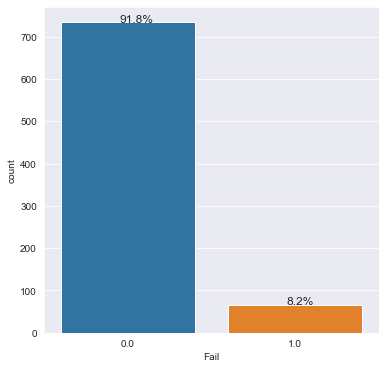

In [6]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax = sns.countplot(data=df, x='Fail')
display_percent_count_plot(ax, df['Fail'],1)
plt.show()

As we can see from the above count plot, the target classes are quite imbalanced. It's reasonable to think that, in a sufficiently large number of cycles, the equipment stops its operation due to failures only a small number of times. On the other hand, from a statistical perspective, imbalanced observations in target classes may cause the model a pretty high accuracy in predicting the majority class, but it will fail to capture the minority class; which is the point of creating a model in the first place.

#### Cycle analysis


In the cycle analysis, I investigate failures against the number of cycles. I aim for calculating the number of failures, the ratio of failures per cycle, the number of subsequent failures (NSF), and the average number of failures between non-subsequent failures.

<AxesSubplot:xlabel='Cycle', ylabel='Fail'>

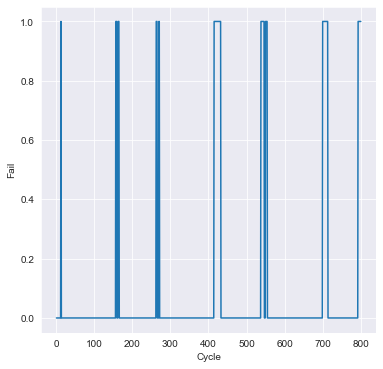

In [7]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

y = df['Fail']
x = df['Cycle']

sns.lineplot(x=x,y=y)

The above line plot shows us the occurrence of failures against the number of cycles. In the majority, a failure is followed by a subsequent occurrence of another failure, which means it's likely that the equipment will stop functioning again right after it fails.

Below, we can see the total number of failures, the ratio of failures per cycle, and the number of subsequent failures (NSF). The NSF is large when compared to the total number of failures, i.e., although the probability the equipment stops is only 8,25%, the probability of occurring a subsequent stop is 90.00%; which amounts to a joint probability of 7.42%.

It's also convenient to compute the average number of cycles between non-subsequent failures. This number, 73.4 cycles, tells us that the equipment operates, on average,  pretty much 73 cycles before it fails. 

In [8]:
n_fails     = df['Fail'].sum()
r_fails     = n_fails/df['Cycle'].max()
n_sub_fails = df['Fail'].apply(lambda x: np.NaN if x==False else x).diff().value_counts().values[0]

print('Num. of failures \t Ratio \t\t Num. subsequent failures (NSF)\n')
print('%d \t\t\t %.2f \t\t %d\n' % (n_fails, r_fails, n_sub_fails))

Num. of failures 	 Ratio 		 Num. subsequent failures (NSF)

66 			 0.08 		 56



In [9]:
x=''
for val in df['Fail'].values:
    x = x+str(int(val))
x = x.split('1')
x = [y for y in x if y != '']

avg_len = 0
for row in x:
    avg_len += len(row)
avg_len /= len(x)
print('Average number of cycles between non-subsequent failures: %.2f' % avg_len)

Average number of cycles between non-subsequent failures: 73.40


#### Preset analysis

The presets analysis is intended to categorize failures according to different system configurations.

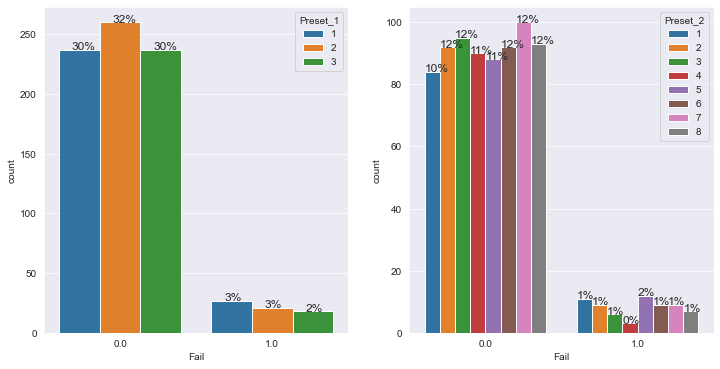

In [10]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

for axis, feat in zip( ax.reshape(-1), df.columns[1:3].values ):
    sns.countplot(data=df, x='Fail', hue=feat, ax=axis)

display_percent_count_plot(ax[0], df['Preset_1'],0)
display_percent_count_plot(ax[1], df['Preset_2'],0)

As we can see from the above chart, it's seemed that presets don't play an important role when it comes to predicting possible failures. Although there may be some differences from one preset to another, it's not that significant. We need to test this hypothesis.

The alternate hypothesis states that there's a relationship between the presets and failures, while the null hypothesis states there's no relationship between them. I'll assume a significance level of 7% to address this issue, i.e., failure observations when Preset_${1,2}$ vary should differs at least 7% from one to another.

The calculations below tell us to reject the null hypothesis. Although presets represent a relatively small significance in failures, they're still important to determine whether a failure may occur.

In [11]:
## relative deviation for Preset_1
is_fail = df[df['Fail']==True]
counts  = is_fail['Preset_1'].value_counts()
abs(counts.diff(-1))/counts

1    0.222222
2    0.142857
3         NaN
Name: Preset_1, dtype: float64

In [12]:
## relative deviation for Preset_2
is_fail = df[df['Fail']==True]
counts  = is_fail['Preset_2'].value_counts().sort_index()
abs(counts.diff(-1))/counts

1    0.181818
2    0.333333
3    0.500000
4    3.000000
5    0.250000
6    0.000000
7    0.222222
8         NaN
Name: Preset_2, dtype: float64

#### Physical attributes analysis


In the analysis of the physical attributes, I categorize failures according to the sensors' readings (temperature, pressure, etc.).

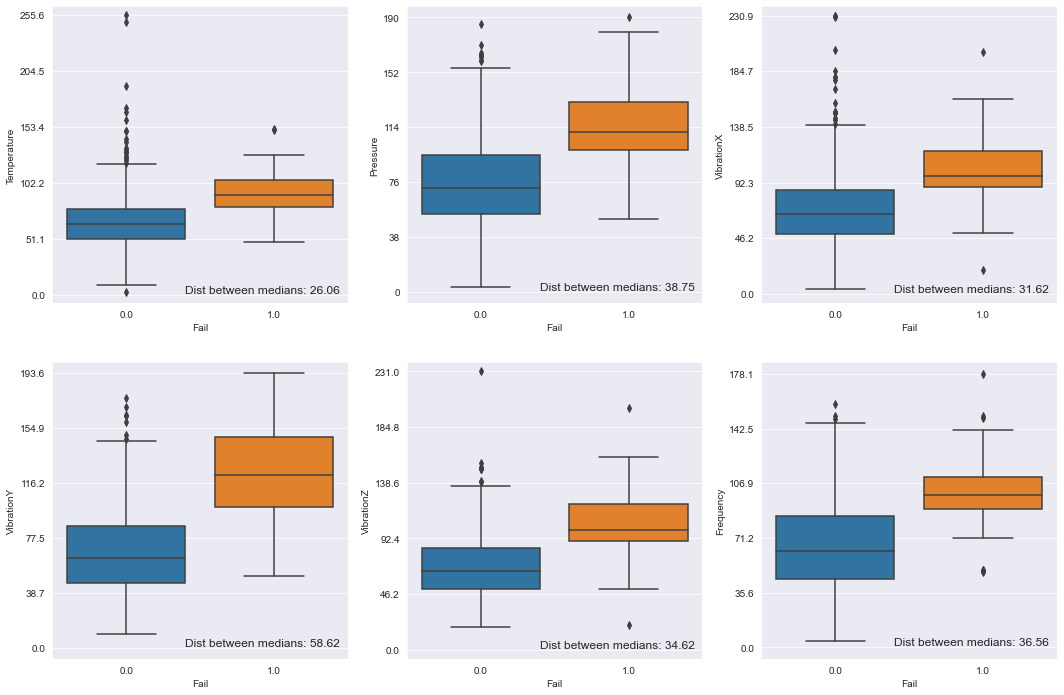

In [13]:
fig, ax = plt.subplots(2,3, figsize=(18,12))

for axis, feat in zip( ax.reshape(-1), df.columns[3:9].values ):
    sns.boxplot(data=df, x='Fail', y=feat, ax=axis)
    diff_medi = dist_medians(df, feat, 'Fail')
    axis.set_ylim(-7.5,df[feat].max()+7.5)
    axis.set_yticks(np.linspace(0,df[feat].max(), num=6))
    axis.text(x=0.4,y=1.0,s='Dist between medians: %.2f' % diff_medi, fontsize=12)

First, it's worth mentioning that, according to the above visualizations, whenever the equipment fails, all physical attributes verge on higher values. Although higher values of frequency, for instance, do not always indicate failures, from a statistical point of view, operating on appropriate levels of temperature, pressure, and vibrational frequency, may prevent unexpected brakes. 

Qualitatively, by observing the previous box plots, it's apparent that the feature "VibrationY" is the most relevant when categorizing failures; outliers when "Fail" is false do not outpace the maximum value when "Fail" is true. Pretty much for the same reason, one could say that "Pressure" is the second most relevant feature. 

Quantitatively, I've taken the difference between medians to rank features by their relevance; higher differences in medians make it easier to classify failures since it indicates that different distributions may not overlap too much. The numerical results reassure my previous qualitative evaluation.

## Feature Engineering

After performing an EDA, it's apparent that there's a correlation between the number of cycles and failures. It's reasonable to think that, after a failure, the equipment can operate rather properly over a certain number of cycles befores it fails again. Having said this, I'm creating two features called "Cycles_wf" which stands for "Cycles without failing", and "Cycles_uf" which stands for "Cycles until failure". 

The variable "Cycles without failing" will allow me to create a classifier model that gives a better estimation about the probability of failure. On the other hand, the variable "Cycles until failure" will be the target variable of a regression model that predicts the number of cycles the equipment may still operate until it stops.

In [14]:
## --- Feature engineering
i=0 
cyc_wf = []
for val in df['Fail']:
    i = i + 1 if val==False else 0
    cyc_wf.append(i)
    
df['Cycles_wf'] = cyc_wf
df['Cycles_uf'] = 0

y = np.array([])
for i in x:
    y = np.append(y,np.arange(1,len(i)+1,dtype='int16')[::-1])
    
df.loc[df[df['Fail']==False].index, ['Cycles_uf']] = y

## Correlation Analysis

Here we check for correlations between predictors, and how the numerical values of the predictors are distributed.


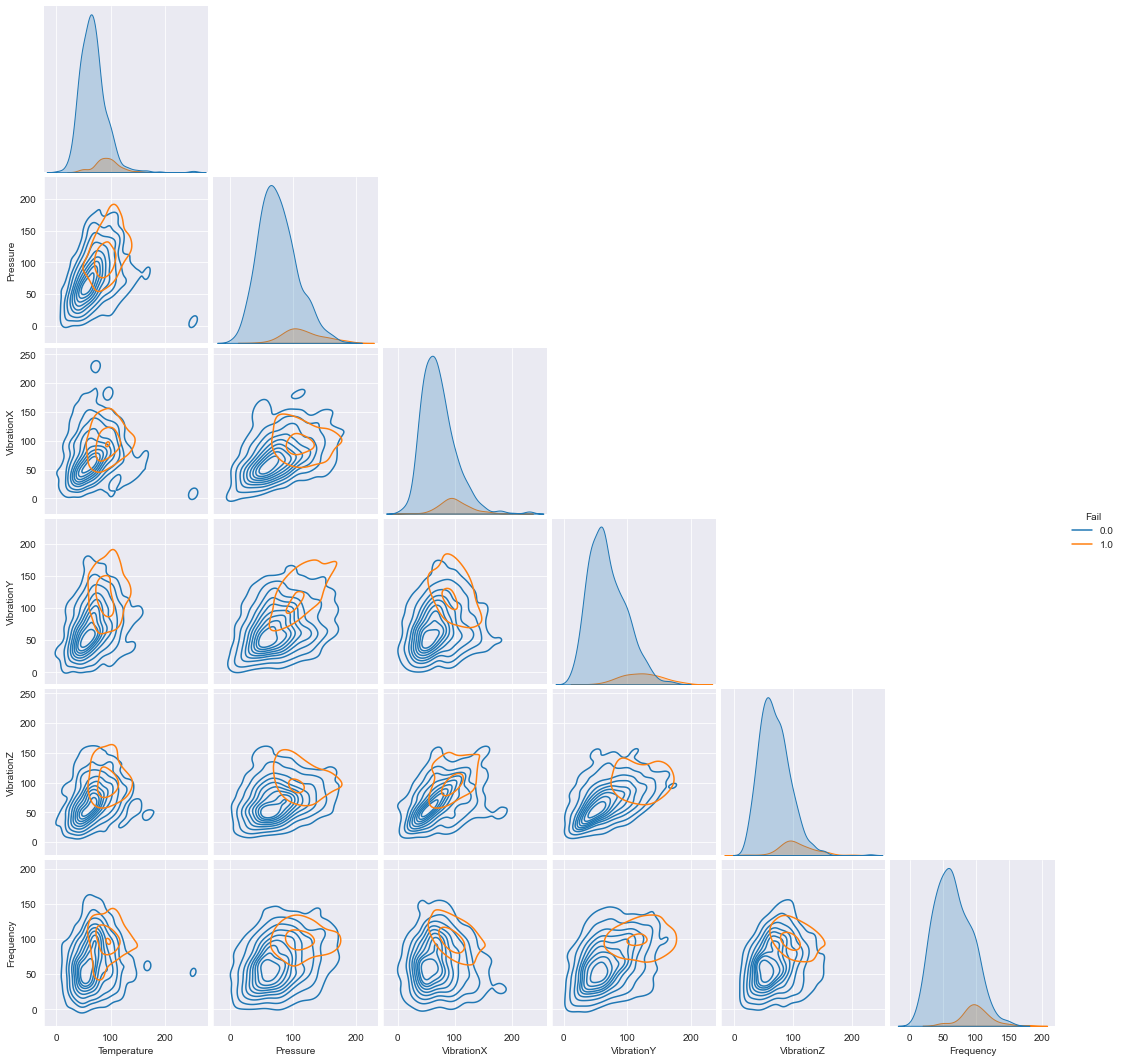

In [15]:
## --- Pair Plot
sns.pairplot(data=df[df.columns[3:10]], hue='Fail', kind='kde', diag_kind='kde', corner=True)

This pair plot tells us that all distributions are pretty much bell-shaped, being a bit right-skewed. Further, distributions when "Fail" equals "False" overlap distributions when "Fail" equals "True" the most; being "VibrationY" the less overlapping. 

As I've mentioned before, there's a trend to increase values in the physical attributes whenever the equipment fails. In summary, this visualization reassures my previous observations.

<AxesSubplot:>

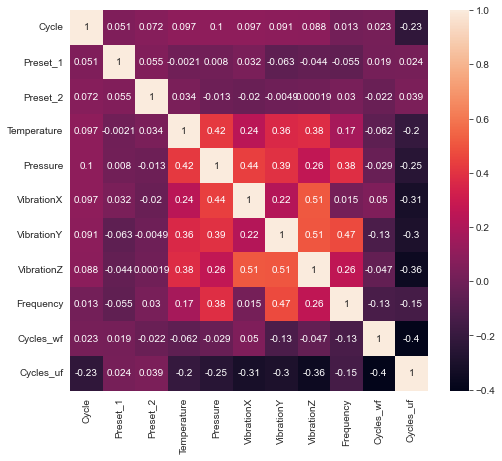

In [16]:
## --- Correlation Matrix

fig, ax = plt.subplots(1,1,figsize=(8,7))

sns.heatmap( df.loc[:,~(df.columns.isin(['Fail']))].corr(), annot=True, ax=ax)

From the correlation matrix we can see there's no strong correlations between variables, being the vibrational degrees of freedom the most correlated. Furthermore, presets are weakly correlated to physical attributes relevant to detecting failures, which reinforces the previous analysis. 

Although the engineered variables have weak correlation with other variables, it's still more correlated to relavant variables, namely, "VibrationY" and "Frequency", than "Cycle", so that some improvement in classifying observations may come up.

## Feature Importance

In this section I use three different approaches to categorize features according to their relevance in predicting failures.

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
Cycle,0.188279,-0.343761,-0.447343,0.416903,-0.530925,-0.431462,0.050703,-0.042602,-0.035720,0.002141
Preset_1,-0.045378,-0.367284,-0.467892,-0.754875,-0.153306,0.109213,0.172471,0.101530,0.003030,-0.006403
Preset_2,0.015711,-0.039482,-0.726796,0.321485,0.519256,0.300239,-0.007827,-0.081376,0.036885,-0.006862
Temperature,0.641491,-0.082799,-0.060506,-0.021918,0.074407,-0.029537,-0.502263,0.533953,-0.143480,0.119895
Pressure,0.718486,-0.068735,0.007404,-0.112855,-0.156014,0.183979,-0.432587,-0.372697,0.126783,-0.259261
VibrationX,0.590927,-0.536070,0.222792,-0.064958,0.272787,-0.121095,0.067451,-0.373095,-0.031763,0.277480
VibrationY,0.754493,0.273442,-0.024974,0.033634,-0.096904,0.051700,0.263995,0.184437,0.478310,0.104462
VibrationZ,0.735474,-0.146894,0.141791,0.051896,0.253824,-0.128311,0.426116,0.189850,-0.195589,-0.281407
Frequency,0.552404,0.537990,-0.137734,-0.017962,-0.289498,0.329592,0.166379,-0.176770,-0.343891,0.133207
Cycles_wf,-0.132043,-0.549016,0.250695,0.286968,-0.260254,0.658216,0.097992,0.162878,0.008040,0.004729


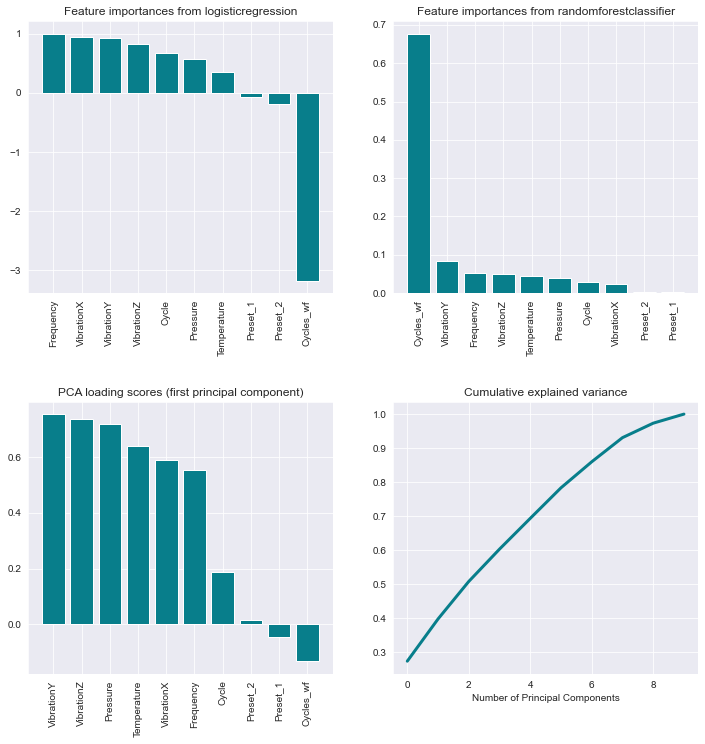

In [17]:
X = df.drop(['Fail','Cycles_uf'], axis=1).copy()
y = df['Fail'].astype('int8')

fig, ax  = plt.subplots(2,2,figsize=(12,12))
loadings = display_feat_import(X, y, ax)

plt.subplots_adjust(hspace=0.4)
loadings

Probably the easiest way to examine feature importances is by examining the model’s coefficients. For example,logistic regression, top-left chart on the above grid, boils down to an equation in which coefficients (importances) are assigned to each input value. Put simply, if an assigned coefficient is a large (negative or positive) number, it has some influence on the prediction. Having said this, a logistic regression model classify "Cycles_bf" as the most relevant predictor, followed by the vibrational degrees of freedom; which is in accordance to our previous analyis.

Another approach is through a tree-based model. After training a tree-based model, we can have access to the 'feature_importances_' property. Obtaining importances in this way is effortless, but the results can come up a bit biased. The tendency of this approach is to inflate the importance of continuous features or high-cardinality categorical variables. Essentially, results from the random forest classifier tell us almost the same we got from the logistic regression classifier.

As a last try, we can obtain importances from PCA loading scores. These are just coefficients of the linear combination of the original variables from which the principal components are constructed. We can use loadings to find correlations between actual variables and principal components. Although this method gives high importance to the vibrational variables, as occurred with other methods, it does not give much relevance to the number of cycles before the equipment fail - considering only the first principal component.

We can also see the cumulative explained variance as a function of number of principal components. This visualization tells us that the first five principal components explains 80% of the variance in the dataset.



#### Cycles Until Failure vs Cycles Without Failing, VibrationY, and Frequency

Let's have a look at the relation between one of the targets, "Cycles until failure", and three relavant variables, namely, cycles without failing, VibrationY, and Frequency.

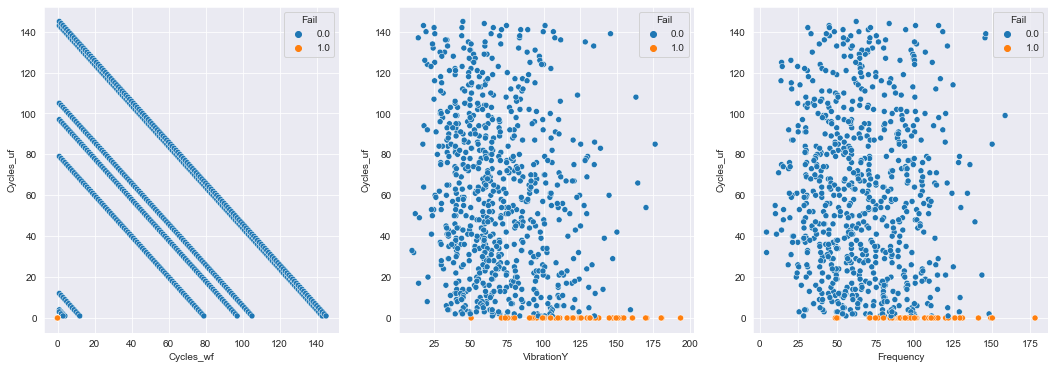

In [18]:
fig, ax = plt.subplots(1,3, figsize=(18,6))

for axis, x in zip( ax, ['Cycles_wf', 'VibrationY', 'Frequency'] ):
    sns.scatterplot(data=df, x=x, y='Cycles_uf', ax=axis, hue='Fail')

It's clear that there's no straightforward relation between the y-axis and the x-axis when the independent variable refers to a vibrational degree of freedom. 

On the other hand, when we look at the relation between "Cycles_uf" and "Cycles_wf", we see perfect negative-slope straight lines, as one could expect. It's an indication that the model should be able to decide to which line an observation may belong - this statement suggest me a tree-based model would do the job well.

## Baseline Models

Here I test separately two classes of algorithms, namely, regressors and classifiers. 

For regressors, I've chosen the following: **RandomForest**, **Lasso**, and **Ridge**. For classifiers, I go for: **Logistic Regression**, **RandomForest**, **SVC**, and **Gaussian Naive Bayes**.

There are a number of reasons for me to choose tree-based models for this task. First, random forests can solve both types of problems that is classification and regression and do a decent estimation at both fronts. Further, it has an effective built-in method for estimating missing data and maintains accuracy when large proportion of the data are missing, which makes this reliable for production. It also has methods for balancing errors in data sets where classes are unbalanced, which is our case.

Although random forests seem to be a suitable choice for this task, I test other kinds of models so that I can compare performances and select the best ones.

#### Regressors

I first train regression models to predict the number of cycles before the equipment fails. The metric used for evaluation was the Root Mean Square Error (RMSE).

In [19]:
rfr_reg = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=40,max_depth=10, random_state=42))

las_reg = make_pipeline(StandardScaler(), Lasso())

rid_reg = make_pipeline(StandardScaler(), Ridge())

In [20]:
X = df.drop(['Fail','Cycles_uf','Preset_1','Preset_2'], axis=1).copy()
y = df['Cycles_uf'].astype('int16')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

models={'RandomForest Regression':rfr_reg.fit(X_train,y_train),
        'Lasso Regression':las_reg.fit(X_train,y_train),
        'Ridge Regression':rid_reg.fit(X_train,y_train)}

rmse= []
for model in models:
    rmse.append( np.sqrt(mean_squared_error(y_test,models[model].predict(X_test) )) )

##### Evaluations

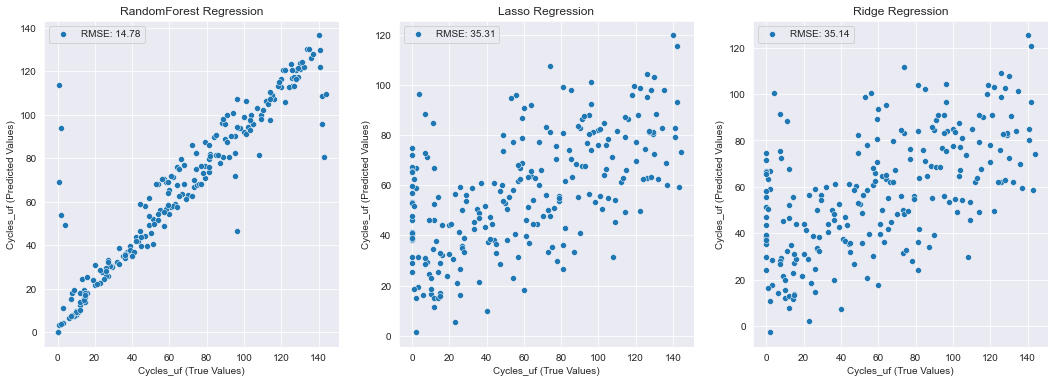

In [21]:
fig, ax = plt.subplots(1,3, figsize=(18,6))

for axis, model, err in zip( ax.reshape(-1), models, rmse ):
    sns.scatterplot(x=y_test, y=models[model].predict(X_test),ax=axis, label='RMSE: %.2f' % err)
    axis.set_title(model, fontsize=12)
    axis.set_xlabel('Cycles_uf (True Values)')
    axis.set_ylabel('Cycles_uf (Predicted Values)')

As we can see, the RandomForest regressor did the best job in predicting the number of cycles before failure.

#### Regression with PyCaret

Now I use the *setup* function from PyCaret to initialize a training environment and create a transformation pipeline. The intention is using PyCaret to automatize the task of training and selecting models. Further, the data will be tested on 25 ML algorithms so that we can take the best one. 

In [23]:
## --- Auto Model Selection
from pycaret.regression     import setup, compare_models, plot_model

s = setup(df.drop('Fail', axis=1), 
          target               = 'Cycles_uf',
          numeric_features     = ['Cycle','Temperature','Pressure','VibrationX',
                                  'VibrationY','VibrationZ','Frequency','Cycles_wf'],
          categorical_features = ['Preset_1','Preset_2'],
          train_size           = 0.75,
          remove_outliers      = True,
          fold_strategy        = 'timeseries',
          fold                 = 5,
          session_id           = 42)

best_model = compare_models(n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,7.4406,265.3681,14.2070,0.8521,0.7614,1.1459,0.0300
xgboost,Extreme Gradient Boosting,9.6899,306.5350,16.6951,0.8236,0.7141,1.3051,45.7460
catboost,CatBoost Regressor,9.8587,336.5137,16.7136,0.8080,0.8583,1.3840,1.5580
rf,Random Forest Regressor,13.4940,433.8186,19.9222,0.7531,0.7752,1.5267,0.1880
et,Extra Trees Regressor,16.3237,593.7750,23.9109,0.6622,1.0330,1.4302,0.1680
lightgbm,Light Gradient Boosting Machine,15.0166,602.0265,23.4637,0.6586,1.0051,1.4130,0.1720
knn,K Neighbors Regressor,15.6463,638.8254,24.9422,0.6367,1.1485,1.4590,0.0300
dt,Decision Tree Regressor,12.5305,699.3137,24.8898,0.6065,0.7558,1.1595,0.0100
ada,AdaBoost Regressor,21.5021,748.2268,27.0035,0.5768,1.0526,2.0663,0.0200
br,Bayesian Ridge,25.9627,1125.0119,33.4423,0.3585,1.3382,1.8070,0.0080


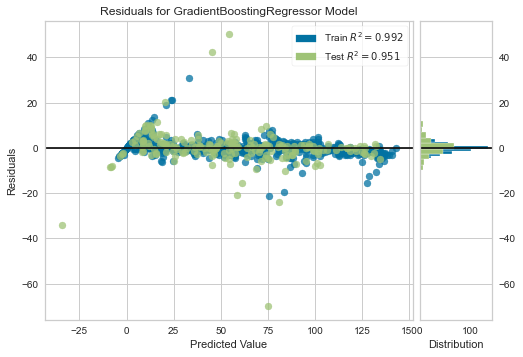

In [24]:
plot_model(best_model[0], plot = 'residuals')

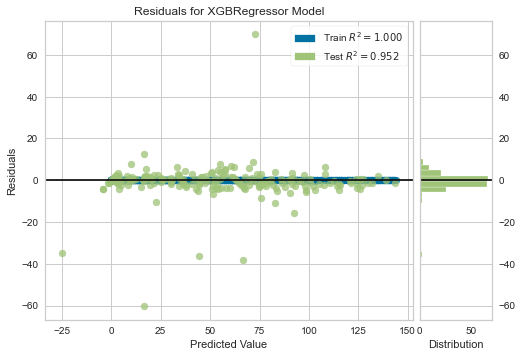

In [25]:
plot_model(best_model[1], plot = 'residuals')

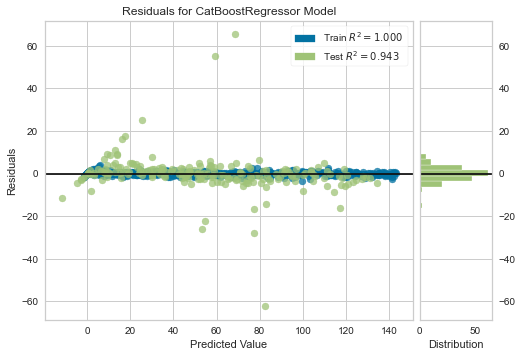

In [26]:
plot_model(best_model[2], plot = 'residuals')

As we can see from the above plots, all residuas have a high density of points close to the origin and a low density of points away from the origin. Further, all of them are symmetric about the origin; which confirms the normality of the residuals.

To conclude, I'd say that the **Gradient Boosting** regressor would fit well for this task since it has one of the highest $R^2$ on the test data and a significantly lower training time.

#### Classifiers

Now I train the classifiers to predict whether an observation indicates high probability of failure. The metrics used for evaluation was accuracy and recall.

In [27]:
log_clf = make_pipeline(StandardScaler(), LogisticRegression())

rnd_clf = make_pipeline(StandardScaler(), RandomForestClassifier(max_depth=6, random_state=42))

svc_clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))

gnb_clf = make_pipeline(StandardScaler(), GaussianNB())

In [28]:
X = df.drop(['Fail','Cycles_uf'], axis=1).copy()
y = df['Fail'].astype('int8')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

models={'Logistic Regression':log_clf.fit(X_train,y_train),
        'RandomForest Classifier':rnd_clf.fit(X_train,y_train),
        'SVC':svc_clf.fit(X_train,y_train),
        'GaussianNB':gnb_clf.fit(X_train,y_train)}

##### Evaluations

In [29]:
## --- Accuracy
acc = {model:accuracy_score(y_test, models[model].predict(X_test)) for model in models}
print('Accuracies:')
acc

Accuracies:


{'Logistic Regression': 0.975,
 'RandomForest Classifier': 1.0,
 'SVC': 0.9708333333333333,
 'GaussianNB': 1.0}

We first evaluate the models according to their accuracy, which shows how many of the predictions are correct. Although the results may seem fantastic, in our case, looking only to accuracy may lead us to erroneous conclusions. 

As I've mentioned earlier, the dataset has an extremely unbalanced class distribution. Almost 92% of the observations belong to the class "Fail = False", and only 8% are in class "Fail = True".

It's crucial to us to detect class "Fail = True" correctly and we cannot afford to misclassify any samples from this class. In that case, we need other metrics to evaluate our models.

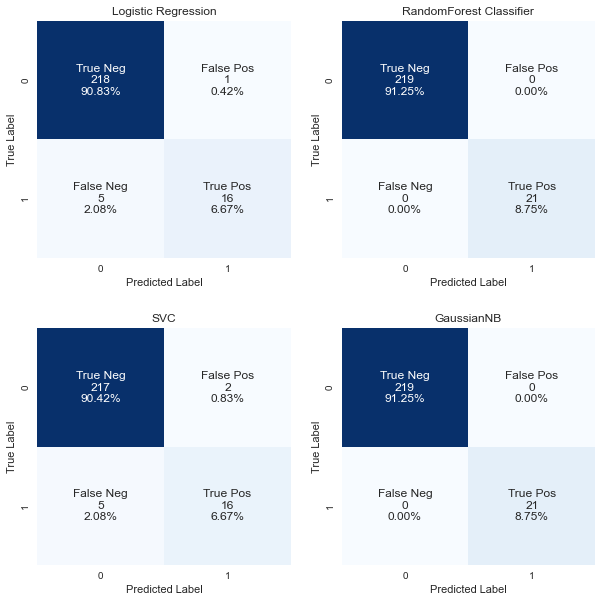

In [30]:
## --- Confusion Matrix

fig, ax = plt.subplots(2,2, figsize=(10,10))

for model, axis in zip(models, ax.reshape(-1)):
    cm = confusion_matrix(y_test, models[model].predict(X_test))
    sns.heatmap(cm, annot=cf_matrix_labels(cm), fmt='', cmap='Blues', ax=axis, cbar=False)
    axis.set_xlabel('Predicted Label')
    axis.set_ylabel('True Label')
    axis.set_title(model)

plt.subplots_adjust(hspace=0.3)

A confusion matrix is not a metric to evaluate a model, but it provides insight into the predictions. The confusion matrix goes deeper than classification accuracy by showing the correct and incorrect (i.e. true or false) predictions on each class. The desired outcome is that the prediction and actual class are the same

Ranking classifiers according to their ability to predict failures in the equipment, as we can see, the GaussianNB classifier and the RandomForest classifier outperformed the other two classifiers; actually, they performed no misclassification despite the fact that classes are quite unbalanced in the dataset. 

Below we can have a look at classification reports for each one of the tested models. Since we are interested in correctly capturing failures in the equipment, without missing a possibility of failure, a more suitable metric to evaluate our model is "recall". The focus of recall is actual positive classes. It indicates how many of the positive classes the model is able to predict correctly.

Again, these reports show us that the GaussianNB classifier and the RandomForest classifier outperformed the other two models. Not only do these two models excel in predicting positive classes, but also it classified all "Not Fail" samples accordingly. Considering the used data and the metrics evaluated here, the RandomForest classifier and the GaussianNB classifier would suit perfectly for monitoring failures in the equipment.


In [31]:
## --- Classification Report
for model in models:
    print(model)
    print(classification_report(y_test, models[model].predict(X_test), target_names=['Not Fail', 'Fail']))
    print('\n')

Logistic Regression
              precision    recall  f1-score   support

    Not Fail       0.98      1.00      0.99       219
        Fail       0.94      0.76      0.84        21

    accuracy                           0.97       240
   macro avg       0.96      0.88      0.91       240
weighted avg       0.97      0.97      0.97       240



RandomForest Classifier
              precision    recall  f1-score   support

    Not Fail       1.00      1.00      1.00       219
        Fail       1.00      1.00      1.00        21

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240



SVC
              precision    recall  f1-score   support

    Not Fail       0.98      0.99      0.98       219
        Fail       0.89      0.76      0.82        21

    accuracy                           0.97       240
   macro avg       0.93      0.88      0.90       240
weighted avg       0.9

#### Classification with PyCaret

Now I repeat the previous step of creating a pipeline with PyCaret, but this time I aim for the classification task.

In [41]:
## --- Auto Model Selection

from pycaret.classification import setup, compare_models, plot_model

s = setup(df_clf, 
          target               = 'Fail',
          numeric_features     = ['Cycle','Temperature','Pressure','VibrationX',
                                  'VibrationY','VibrationZ','Frequency','Cycles_wf'],
          categorical_features = ['Preset_1','Preset_2'],
          train_size           = 0.75,
          remove_outliers      = True,
          fold_strategy        = 'timeseries',
          fold                 = 5,
          session_id           = 42)

best_model = compare_models(n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0060
ada,Ada Boost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0080
gbc,Gradient Boosting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0280
lightgbm,Light Gradient Boosting Machine,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1780
catboost,CatBoost Classifier,0.9979,1.0000,0.9667,1.0000,0.9818,0.9807,0.9816,1.6600
rf,Random Forest Classifier,0.9874,1.0000,0.8000,0.8000,0.8000,0.8000,0.8000,0.1960
xgboost,Extreme Gradient Boosting,0.9853,0.9899,0.8000,0.8000,0.8000,0.7963,0.7946,8.0460
lr,Logistic Regression,0.9768,0.9907,0.7845,0.8333,0.7933,0.7815,0.7900,0.5560
nb,Naive Bayes,0.9705,0.8272,0.5877,0.8000,0.6506,0.6434,0.6644,0.0060
et,Extra Trees Classifier,0.9579,0.9897,0.4389,0.6000,0.4945,0.4875,0.5009,0.2000


The results show us that that the top-3 classifiers performed equally good but the Decision Tree classifier had the shortest training time. Since decisino trees prone to overfit, I'll selec the Ada Boost Classifier.

## Hyperparameter Fine Tunning

Finally, I will fine-tune the Gradient Boost algorithm to find the parameters combination that delivers the best possible performance. The best possible performance is the one that gives the highest RMSE score.

In [ ]:
X = df.drop(['Fail','Cycles_uf'], axis=1).copy()
y = df['Cycles_uf'].astype('int16')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

param_grid = {'loss'           : ['ls', 'lad', 'huber','quantile'],  
              'max_depth'      : [3,5,10],
              'learning_rate'  : [0.95,0.1,1.15],
              'n_estimators'   : [70,90,110],
              'criterion'      : ['friedman_mse', 'mse', 'mae']}
                
grid = GridSearchCV(GradientBoostingRegressor(), 
                    param_grid, 
                    refit   = True, 
                    verbose = 3, 
                    n_jobs  = -1, 
                    scoring ='r2') 

## --- fitting GridSearch
grid_result = grid.fit(X_train, y_train)
best_params = grid_result.best_params_
print(best_params)

In [55]:
print(best_params)

{'criterion': 'mae', 'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 10, 'n_estimators': 110}


## Final Product

Considering the previous analysis and tests, I'd deliver the following solution: use a combination of a regressor and a classifier so that the output would give the number of cycles before the equipment fails and the current probability of failure.

For the regressor, I'd select the GradientBoost regressor since it gave the lower RMSE. For the classifier, I'd choose the AdaBoost classifier since it gives better estimates of probabilities when compared to the NaiveBayes classifier.

The following lines give us an idea about how this model would work when it's in production.

In [78]:
X_reg = df.drop(['Fail','Cycles_uf'], axis=1).copy()
y_reg = df['Cycles_uf'].astype('int16')

X_clf = df.drop(['Fail'], axis=1).copy()
y_clf = df['Fail'].astype('int8')

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.25, random_state=42)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.25, random_state=42)

sel_reg = make_pipeline(StandardScaler(), GradientBoostingRegressor(criterion     = 'mae',
                                                                    learning_rate = 0.1,
                                                                    loss          = 'ls',
                                                                    max_depth     = 10,
                                                                    n_estimators  = 110))
sel_reg = sel_reg.fit(X_train_reg, y_train_reg)

sel_clf = make_pipeline(StandardScaler(), AdaBoostClassifier())
sel_clf = sel_clf.fit(X_train_clf, y_train_clf)

In [79]:
X_test_clf['Cycles_uf'] = sel_reg.predict(X_test_clf.drop('Cycles_uf', axis=1))

predicted_cyc = X_test_clf['Cycles_uf']
predicted_clf = sel_clf.predict(X_test_clf)
probas        = sel_clf.predict_proba(X_test_clf)[:,1]

results = pd.DataFrame({'Cycles_uf':predicted_cyc,
                        'Cycles':X_test_reg['Cycle'],
                        'Fail':predicted_clf,
                        'Prob_Fail':probas})

a         = df[df['Fail']==True]['Cycle'].diff() != 1
true_fail = df.iloc[a[a==True].index]['Cycle'].values

## -- percentual reduction of non-subsequent failures

reduc = 100*df[df['Fail']==True]['Cycle'].isin(true_fail).sum()/len(df[df['Fail']==True]['Cycle'])
print('Reduction of unexpected failures: %.2f%%' % reduc)

Reduction of unexpected failures: 15.15%


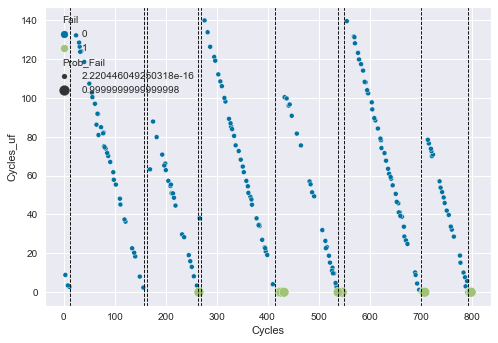

In [82]:
sns.scatterplot(data=results, x='Cycles', y='Cycles_uf', hue='Fail', size='Prob_Fail')

for coord in true_fail:
    plt.axvline(x=coord, ls='--', c='black', lw='0.9')

The above graph shows us, as one could expect, that the number of cycles until failure drops down as the number of cycles increases. The dashed vertical lines indicate where failures actually occurred. Also, the probability of failure tends to increase whenever a failure gets closer. These results can be monitored so that they can support decision-makers to schedule maintenances and prevent unexpected stops.

Considering only the non-subsequent failures as unexpected failures, this solution reduces the total number of failures by 15%

#### Further steps

As one further step, if more time were available, I'd propose creating regression models to predict the sensors' readings in the subsequent cycle of operation so that we can estimate the probability of failure in advance.

Besides, once this model gets into production, one should constantly update its training data so that the model may capture new causes of failures.